In [4]:
import cv2
import numpy as np

from sklearn.cluster import KMeans
from scipy import ndimage

%matplotlib notebook
import matplotlib.pyplot as plt

# Le clustering

#### Plan

 1. Importation d'une image
 1. Clustering de couleurs (K-Means)
     * Création des clusters
     * Affichage des clusters
     * Tranformation des couleurs
 1. Création d'un dataset II

## Importation d'une image

<IPython.core.display.Javascript object>


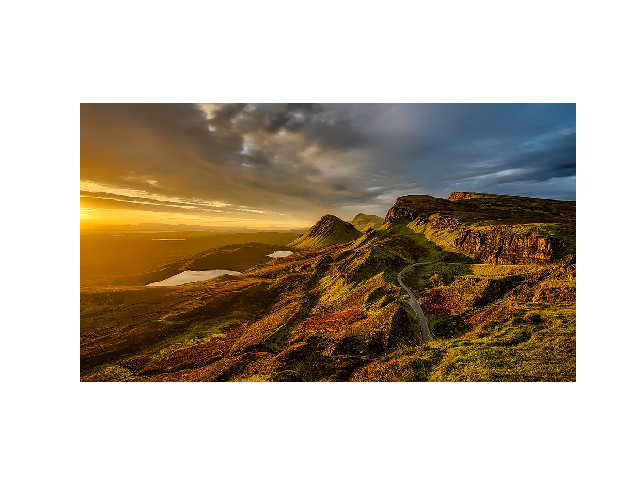

(540, 960, 3)


In [13]:
image = cv2.imread('../data/images/paysage.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure()
plt.axis("off")
plt.imshow(image)
print(image.shape)

## Clustering de couleurs

A travers le choix du nombre de clusters, nous choisissons le nombre de couleurs à conserver.

In [6]:
n_clusters = 8

flatten = image.reshape((-1, 3))

# K-Means from Sklearn
clt = KMeans(n_clusters = n_clusters)
clt.fit(flatten)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Définition de fonctions 
    * Pour récupérer la proportion de chaque cluster
    * Pour afficher la proportion et la couleur des clusters

In [7]:
def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

In [8]:
def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0
    
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX
        
    return bar

#### Application

In [9]:
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

<IPython.core.display.Javascript object>

## Affectation

Chaque pixel sera changé par le cluster où appartient sa couleur.

La première méthode est de regarder de quelle couleur le pixel est le plus proche. Cette méthode est à choisir dans le cas d'une image différente à celle qui a _fit_.

Dans notre cas, c'est la même image donc la seconde méthode consiste à récupérer les labels puis de transformer le label en couleur.

<IPython.core.display.Javascript object>


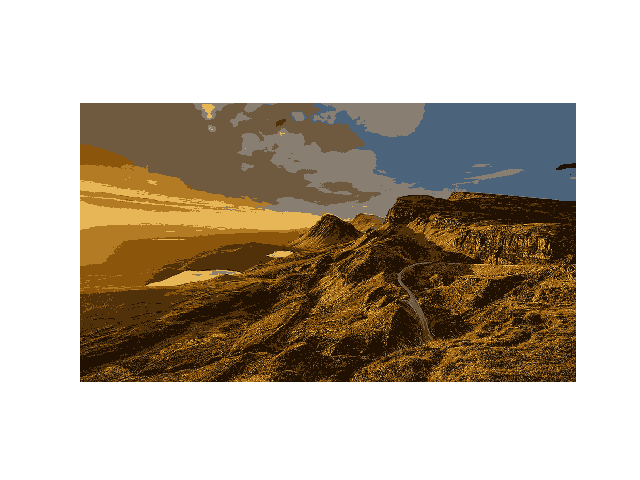

In [17]:
cluster_colors = clt.cluster_centers_

def dist2color(pixel):
    idx = np.where(pixel == np.min(pixel))
    return cluster_colors[idx].astype(np.uint8)

new = clt.transform(flatten)
new = np.apply_along_axis(dist2color, 1, new)

plt.figure()
plt.axis("off")
plt.imshow(new.reshape(540, 960, 3))
plt.show()

<IPython.core.display.Javascript object>


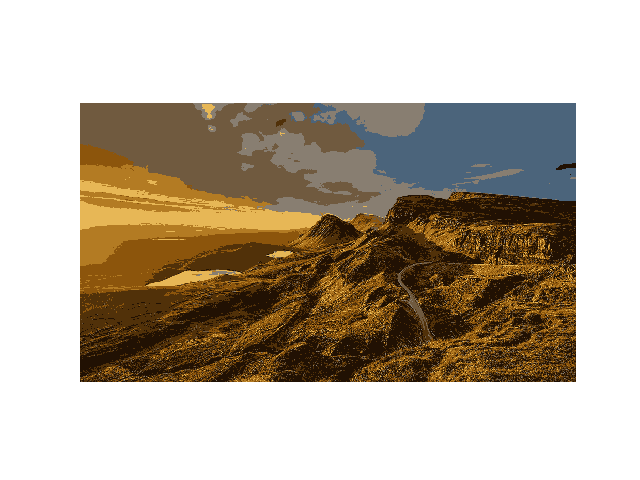

In [54]:
cluster_colors = clt.cluster_centers_

def label2color(pixel):
    return cluster_colors[pixel].astype(np.uint8)

new = clt.labels_
new = np.apply_along_axis(label2color, 0, new)

plt.figure()
plt.axis("off")
plt.imshow(new.reshape(*image.shape))
plt.show()

# Création d'un dataset II

L'idée est de partir d'une image et d'obtenir des valeurs numériques. Par exemple, elles pourront servir pour un algorithme de machine learning.

Les étapes :
 1. Visualisation de l'image
 1. Création des clusters
 1. Analyse des clusters
 1. Binarisation de l'image
 1. Labélisation
 1. Observation des résultats
 1. HSV

<IPython.core.display.Javascript object>


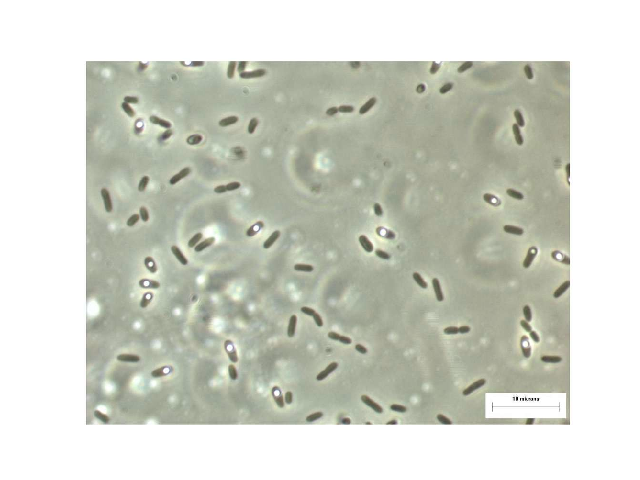

In [29]:
image = cv2.imread("../data/images/bacteries.jpg")
plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

## Clustering

Ce sont les mêmes étapes que lors du clustering de couleur.

Nous choisissons le bon cluster visuellement.

In [30]:
n_clusters = 4

flatten = image.reshape((-1, 3))

clt = KMeans(n_clusters = n_clusters)
clt.fit(flatten)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>


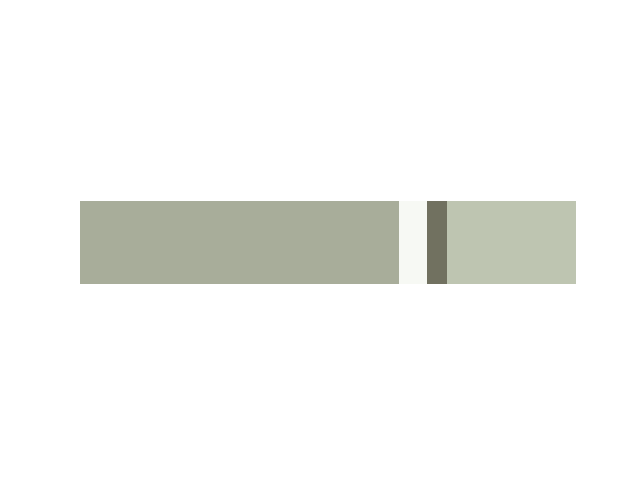

In [31]:
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

<IPython.core.display.Javascript object>


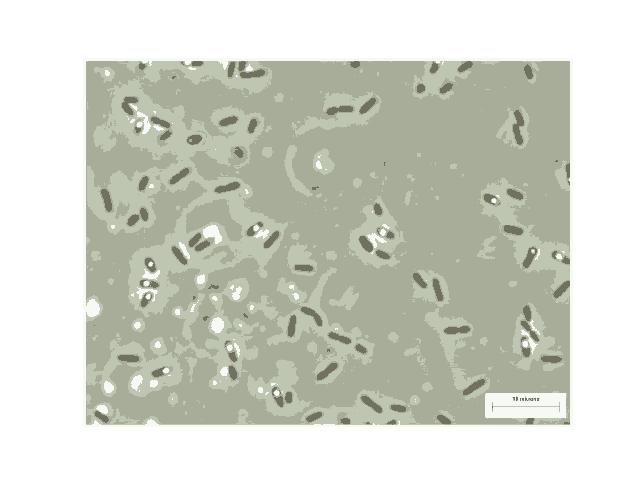

In [32]:
cluster_colors = clt.cluster_centers_

def label2color(pixel):
    return cluster_colors[pixel].astype(np.uint8)

new = clt.labels_
new = np.apply_along_axis(label2color, 0, new)

plt.figure()
plt.axis("off")
plt.imshow(new.reshape(*image.shape))
plt.show()

## Binarisation

En séléctionant le bon cluster, on garde uniquement la couleur des bactéries.

Ensuite, ce sont les mêmes étapes que lors de la première version de _"Création d'un dataset"_

<IPython.core.display.Javascript object>


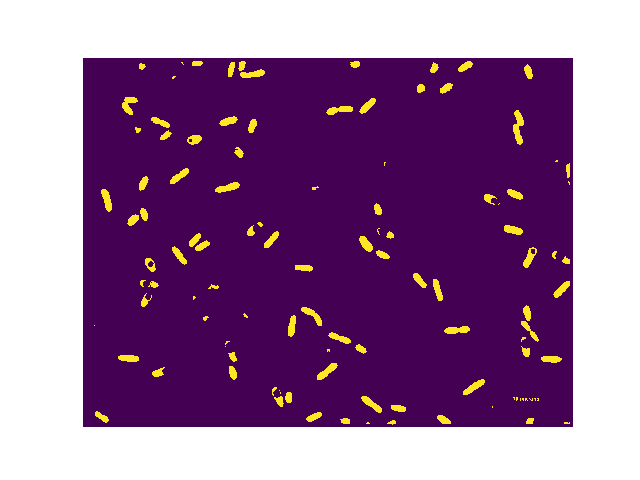

<IPython.core.display.Javascript object>


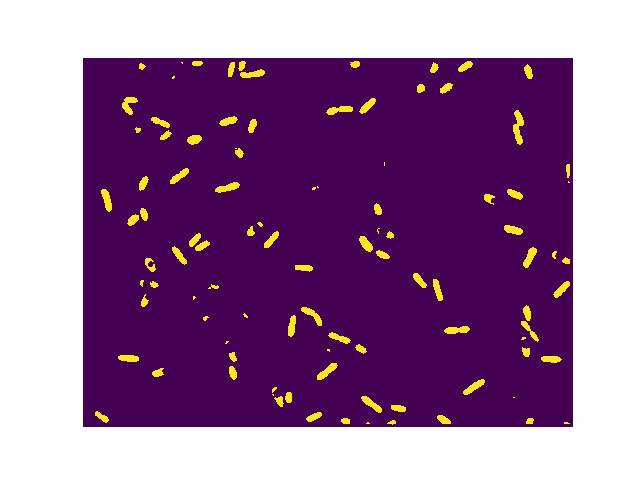

In [34]:
data = clt.labels_
data = data == 2 # /!\ Warning The index of the correct cluster can change
data = data.reshape(*image.shape[:-1])

plt.figure()
plt.axis("off")
plt.imshow(data)
plt.show()

data = ndimage.binary_opening(data)
data = ndimage.binary_fill_holes(data)
plt.figure()
plt.axis("off")
plt.imshow(data)
plt.show()

## Observation

On voit très clairement qu'il y a moins d'impurté qu'avec la méthode des histogrammes. Ce qui donne 20 labels de moins et 12 de moins après application du seuil.

100
(96,)


<IPython.core.display.Javascript object>


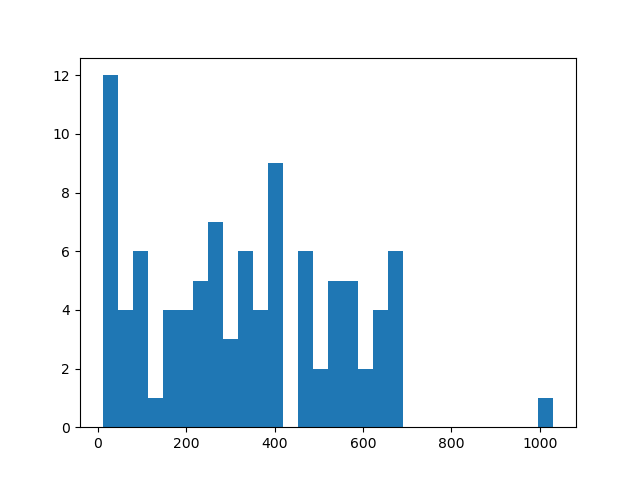

In [37]:
label_image, n_labels = ndimage.label(data)
print(n_labels)

res = ndimage.sum(data, label_image, range(n_labels))
res = res[res > 10]

print(res.shape)

plt.figure()
plt.hist(res, bins=30)
plt.show()

#### HSV

À la place d'utiliser les chanels RGB, le chanel Hue du HSV pourrait aussi fonctionner. Après un test, les résultats sont assez peu exploitables.

NB: En utilisant les 3 chanels du HSV, les résultats sont très similaires à RGB.

In [25]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

n_clusters = 4
flatten = image[:, :, 0].reshape(-1, 1)

clt = KMeans(n_clusters = n_clusters)
clt.fit(flatten)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

(1, 4, 3)


<IPython.core.display.Javascript object>


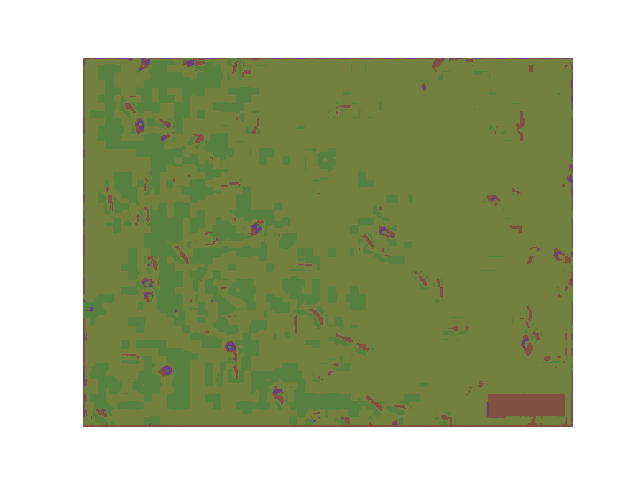

In [26]:
hue = clt.cluster_centers_

# Reconstruct a color from hue
cluster_colors = np.array([[
    [hue[0], 128, 128],
    [hue[1], 128, 128],
    [hue[2], 128, 128],
    [hue[3], 128, 128]
]], dtype=np.uint8)

# Then transform to RGB for diplaying
cluster_colors = cv2.cvtColor(cluster_colors, cv2.COLOR_HSV2RGB)

def label2color(pixel):
    return cluster_colors[0][pixel].astype(np.uint8)

new = clt.labels_
new = np.apply_along_axis(label2color, 0, new)

plt.figure()
plt.axis("off")
plt.imshow(new.reshape(*image.shape))
plt.show()